# word2vec
## 基于推理的方法和神经网络
- 目前使用向量来表达词的方式有两种：基于统计的、基于推理的。
> 统计VS推理:
> - 统计需要统计所有的词，而推理只需要统计一部分词。
> - 统计需要一个手动的转换过程：共现矩阵 -> PPMI -> SVD -> 词向量。
> - 推理是一个端到端的过程
> - 统计是统计的关注的是当前的词，然后统计当前词的上下文分布
> - 推理是用的上下文，然后推理当前词的概率
### 神经网络中的单词处理方法
- 先将单词的ID使用one-hot编码，将每个单词的表达形式转换为一个向量。
- 使用不带权重的全连接层处理输入

In [1]:
import numpy as np
# 创建一个长度为7的one-hot向量
c = np.array([1, 0, 0, 0, 0, 0, 0])
w = np.random.randn(7, 3)
o = np.dot(c, w)
print(f'c: {c}')
print(f'w: {w}')
print(f'o: {o}')

c: [1 0 0 0 0 0 0]
w: [[ 0.5131545   0.87783701 -0.36688675]
 [ 0.7444375   0.78296337 -1.35319267]
 [-0.65190148 -0.47168656 -1.25136106]
 [-0.63880952 -1.34276364  0.47767246]
 [ 0.60687517 -0.76980353 -0.38812992]
 [ 1.67307118 -0.61966046  1.34228413]
 [-1.13779856  0.90732707 -1.10976281]]
o: [ 0.5131545   0.87783701 -0.36688675]


## 简单的word2vec
- 分为cbow和skip-gram两种方法
- cbow: continuous bag of words，以介绍这个技术为主
### cbow模型的推理
- 输入层的个数和定义这个推理模型的时候，对上下文的单词定义个数有关系。比如说定义上下文各有一个单词，那么输入层的个数就是2.如果上下文的单词个数是N，那么输入层的个数就是N
- 多个输入层到中间层的过程是做加法，然后求平均值
- 输入层和输出层的神经元个数都是语料库中单词的个数
- 中间层的神经元个数要比输入层的少，这一点非常重要。因为中间层是在压缩输入层的信息，这个过程可以被称为编码。从中间层向输出层传递信息的过程叫做解码。

In [2]:
# %run ./common/layers.py

In [3]:
import numpy as np
import sys
sys.path.append('./common')
from common.layers import MatMul

In [4]:
# say这个单词的one-hot向量
c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])
# 初始化权重，这里的神经网络层用的是不带偏置的全连接层
w_in = np.random.randn(7, 3)
w_out = np.random.randn(3, 7)
# 生成层
in_layer0 = MatMul(w_in)
in_layer1 = MatMul(w_in)
out_layer = MatMul(w_out)
# 正向传播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
# 查看最后的预测结果
print(f's: {s}')

s: [ 1.67126632 -2.05410664  0.99343605  0.59206925  1.42640723 -0.41941205
  1.57569077]


### 统计VS推理
- 这两种方式都是基于假设理论：单词本身并没有含义，是它的上下文给了它一个含义。
- 统计的方式构建词向量的过程是，根据目标词，统计上下文的信息，最终给出向量的表达形式。即：共现矩阵 -> PPMI -> SVD -> 词向量。
- 推理的方式构建词向量的过程是，根据上下文，通过神经网络，给出目标词的向量表达形式。

In [4]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(f'corpus: {corpus}')
print(f'word_to_id: {word_to_id}')
print(f'id_to_word: {id_to_word}')

corpus: [0 1 2 3 4 1 5 6]
word_to_id: {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
# 创建上下文和目标词
# 与统计创建的长度不同，这个的长度是语料库的长度-上下文长度
def create_contexts_target(corpus, window_size=1):
    # 目标词向量，截取语料库的前段和后端（和上下文的窗口大小有关）
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(window_size * 2 + 1):
            if t != window_size:
                cs.append(corpus[idx - window_size + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)
contexts, target = create_contexts_target(corpus, window_size=1)
print(f'contexts: {contexts}')
print(f'target: {target}')

contexts: [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target: [1 2 3 4 1 5]


上下文和目标词的one-hot矩阵和共现矩阵的差异
- 共现矩阵是一个方阵，它的大小是这个语料库的单词个数
- 共现矩阵是一个对于主对角线对称的方阵，它的第i行或第i列关注的是第i个单词的共现情况
- target的one-hot是一个矩阵，行长度是语料库的长度减去上下文的单词个数，列长度是语料库的单词个数
- contexts的one-hot是一个3D张量，第一维是语料库的长度减去上下文的单词个数，第二维是上下文的单词个数，第三维是语料库的单词个数
- target和contexts的最后一维都要符合one-hot的定义，只有一个1，其他都是0

In [6]:
# 将上下文和目标词转换为one-hot向量
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(f'corpus:\n{corpus}')
print(f'word_to_id:\n{word_to_id}')
print(f'id_to_word:\n{id_to_word}')
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)
print(f'target:\n{target}')
print(f'contexts:\n{contexts}')
print('-------shape--------')
print(f'corpus.shape: {corpus.shape}')
print(f'target.shape: {target.shape}')
print(f'contexts.shape: {contexts.shape}')

corpus:
[0 1 2 3 4 1 5 6]
word_to_id:
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
id_to_word:
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
target:
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
contexts:
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
-------shape--------
corpus.shape: (8,)
target.shape: (6, 7)
contexts.shape: (6, 2, 7)


In [7]:
# 实现简单CBOW模型
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H)
        W_out = 0.01 * np.random.randn(H, V)

        # 定义各层
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 连接输入层和各层
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in
    
    # 定义前向传播
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = 0.5 * (h0 + h1)
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    # 定义反向传播
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

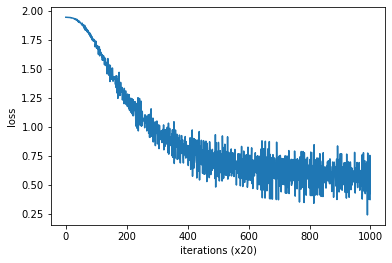

In [8]:
# 学习的实现
import sys
sys.path.append('./common')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [10]:
# 展现推理之后的词向量
word_vecs = model.word_vecs
print(f'word_vecs.shape:\n{word_vecs.shape}')
for word_id in range(vocab_size):
    print(f'{id_to_word[word_id]}: {word_vecs[word_id]}')

word_vecs.shape:
(7, 5)
you: [ 1.15607056 -1.08926645  1.11580262 -1.23243894  1.2156946 ]
say: [-1.24859986  1.22930978 -1.27596134  0.23188643 -0.16094574]
goodbye: [ 0.83224528 -0.88346651  0.83846176 -0.59055074  0.67854497]
and: [-1.06187464  1.03606713 -1.08528119  1.5735629  -1.56127391]
i: [ 0.82939845 -0.90212861  0.82466936 -0.58873626  0.67613132]
hello: [ 1.15415849 -1.08127784  1.10722107 -1.24710605  1.21624041]
.: [-1.02246353  1.00861078 -1.04116119 -1.44753811  1.4769494 ]
